# Analyzing shared interests for two reddit users
#### Ari Bailey

## 1. Introduction
By taking two redditor users (redditors) usernames, I hope to be able to ascertain their shared interests. I aim to do this by looking at users post and comment data as well as subreddit data.

### 1.1 Motivation
It is very popular in the US to say that we exist in one of the most polarized and divisive times in our nation's history (CITE). Truth of this notwithstanding, it is easy to see the role that social media plays in facilitating this. Social media platforms reinforce people's beliefs by introducing them to groups of people who share similar views "outside the norm" as them. The general anonyminity of platforms like reddit -- the so called un-Facebook -- allows users to share their most unpopular and farfetched theories. Reddit users are not limited by how they believe others will percieve their opinions. 

This effect plays both ways, however. Just as reddit users can take pride in the facelessness of both their opinion and those who react to it, subsequent commenters also fail to see the person behind the post. This can lead to drawn out debates between users who find themselves on opposing sides of an ideological coin. These debates, lacking the general understanding of humanity that still exists on both sides, can become angry, vehement and attacking. Users belive that people who share opposite opinions to them are thereby opposite people to them.

Like I mentioned earlier, it's popular in the US to say we live in one of the most divided times in our nation's history. As it turns out; however, we have always been divided on certain views. There have been times in American history, such as the civil war, where we were considerably more divided than now (CITE). 

How can we cut through this illusion? How can we remind people by showing that they have more in common than they might imagine? Why don't we start with social media, the often cited breeding ground for polarization. Let's take a look at reddit, for two reasons. 1) Reddit's system of subreddits allows users to carefully dilineate and interact with topics that interest them by joining groups called subreddits. 2) Reddit has a powerful API that allows one to pull a wealth of publicly avaliable information on any reddit user and subreddits.

By taking any two reddit users, we can attempt to cut down the perception of personal divide. We can do this by showing on what topics do two users agree. If we can show two users that they share common interests in subreddits, then perhaps they might realize that they are not as different as they initially would tend to think.

### 1.2 Libraries Used
We need libraries to store data and plot data. Therefore we have pandas, numpy, matplotlib, and seaborn for data storage and analysis. Sklearn's preprocessing will also be used in our final step of data preperation to normalize data. Additionally we have other libraries that allow us to better store or manage our data. We also need to work with the reddit API. Conveniently, there is a powerful library called PRAW that stands for The Python Reddit API Wrapper. This library allows us to more efficiently and easily pull data from the Reddit's API.

In [3]:
import pandas as pd
import numpy as np
import praw
import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy
from sklearn import preprocessing

I store my reddit API client ID and secret key in a local file. This way I can protect my API from prying eyes. We need to read this file in.

In [4]:
# hide my api access stuff
auth = open("secret", "r").read().split('|')
CLIENT_ID = auth[0]
SECRET_KEY = auth[1]

Now, we need to make a PRAW reddit instance. This will allows us to use the PRAW wrapper to access the reddit API.

In [5]:
# make a PRAW reddit instance
reddit = praw.Reddit (
    client_id=CLIENT_ID,
    client_secret=SECRET_KEY,
    user_agent="CMSC320",
)

# USER_ONE = 'jmct' #professor
# USER_TWO = 'ariqbailey'
USER_ONE = 'ariqbailey'
USER_TWO = 'jmct'

# get users account creation dates
user_one_creation = reddit.redditor(USER_ONE).created_utc
user_two_creation = reddit.redditor(USER_TWO).created_utc

## 2. Comment Data analysis
Redditors tend to make a lot of comments. Because of this, we need to find various metrics to quanitfy which comments represent high levels of interest, and which comments represent lower levels of interest. One way we can do this is by assigning to weights to a few different metrics that could help reflect comment interest. We can then quanitative analyze a comment's 'strength' in any of these particular categories

### 2.1 Load in user one's comments
We can now make use of this reddit instance. Let's use it to load user one's comments as well as some indentifying information for each (contents, length, subreddit posted on, and time created) into a pandas dataframe for later analysis.

In [6]:
# get users comments
LIMIT = None
user_one_comments = reddit.redditor(USER_ONE).comments.new(limit=LIMIT)
one_comment_df = pd.DataFrame(columns=['body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for comment in user_one_comments:
    one_comment_df.loc[i] = [comment.body, len(comment.body), comment.subreddit, comment.created_utc]
    i += 1

In [7]:
one_comment_df.head()

,body,body_length,subreddit,created_utc
0,This is hilarious! Loved the quip about cuttin...,81,OCPoetry,1.619289e+09
1,This is very nicely done. Good job!,35,UMD,1.619274e+09
2,Anyone know if this feature has rolled out to ...,77,kindle,1.618535e+09
3,Ah thank you,12,UMD,1.618440e+09
4,What’s mmWave for the uninitiated? Is that the...,86,UMD,1.618440e+09


For convieniences in visualizing and graphing data, let's make a date column and store the comment date in a more human comprehendible format than epoch time.

In [8]:
# add date column
one_comment_df['date'] = [None] * len(one_comment_df)

# add standard date
for i,r in one_comment_df.iterrows():
    one_comment_df.at[i, 'date'] = datetime.datetime.fromtimestamp(r['created_utc'])

### 2.2 Weighting system based off comment length
One way we can represent the interest a user has in a specific comment is by how much effort they put into writing that comment. The more effort someone puts into discussion a particular topic, the more likely it is that they care or are interested in that topic at some level. The easiest way to quanitfy effort is by comment length. More length translates to more time spend thinking about and writing a comment.


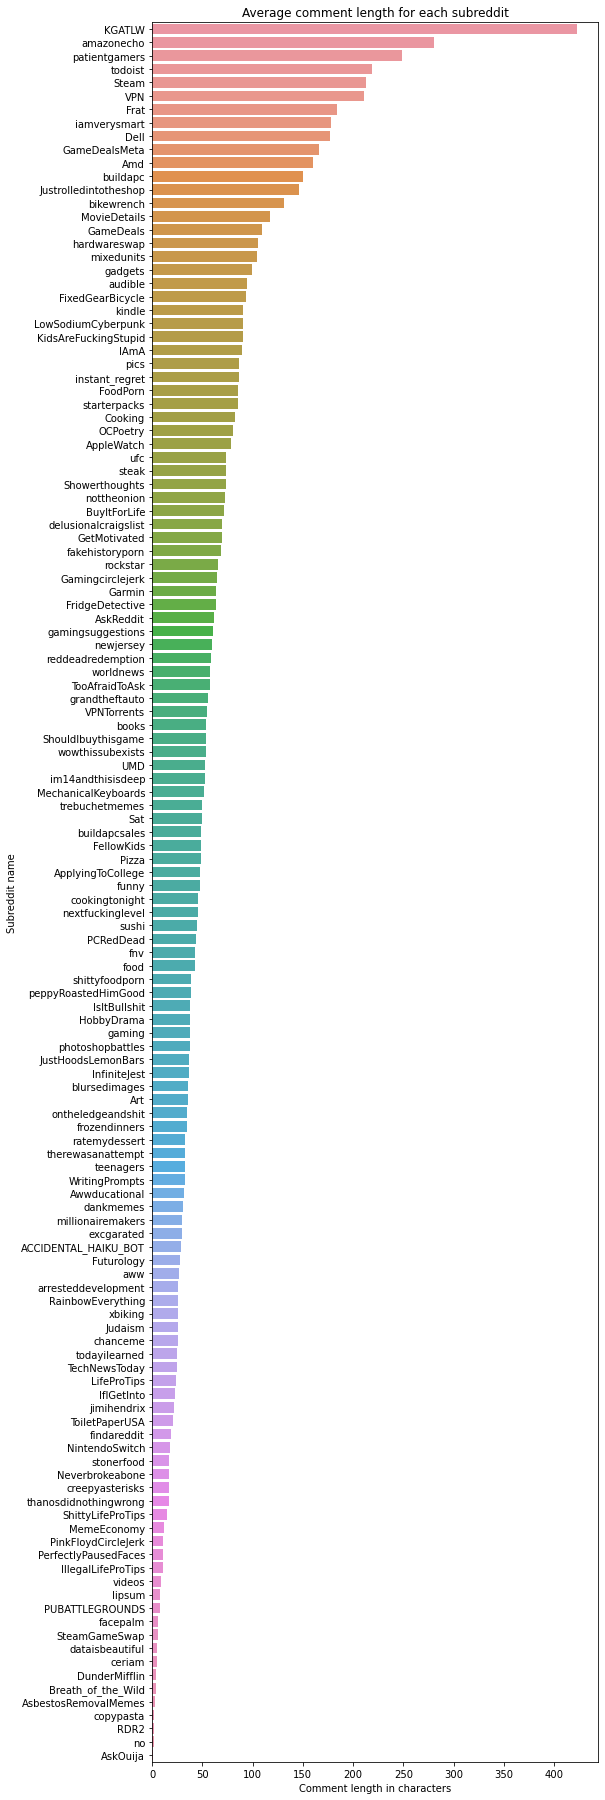

In [9]:
subreddits = {}
for i, r in one_comment_df.iterrows():
    if(not str(r['subreddit']) in subreddits):
        subreddits[str(r['subreddit'])] = [0, 0]

    subreddits[str(r['subreddit'])] = [subreddits[str(r['subreddit'])][0] + r['body_length'], subreddits[str(r['subreddit'])][1] + 1]

sub_avgs = {}
sub_avgs = defaultdict(lambda: 0, sub_avgs)

for k in subreddits:
    sub_avgs[k] = int(subreddits[k][0] / subreddits[k][1])

sub_names_sorted = []
sub_avgs_sorted = []
for i in sorted(sub_avgs.keys(), key=lambda x: sub_avgs[x], reverse=True):
    sub_names_sorted.append(i)
    sub_avgs_sorted.append(sub_avgs[i])

plt.figure(figsize=(8,32))
sns.barplot(x=sub_avgs_sorted, y=sub_names_sorted)
plt.title('Average comment length for each subreddit')
plt.xlabel('Comment length in characters')
plt.ylabel('Subreddit name')
plt.show()

We now want to create a weighting system that has a linear relationship to the comment's body length. We can do this by finding the average comment length across all subreddits for the user, and then representing each comment length as a proportion of that average length.

In [10]:
# generate weights proportional to average comment length for each subreddit
one_avg_comment_len = one_comment_df['body_length'].mean()

one_comment_df['length_weight'] = [None] * len(one_comment_df)

for i,r in one_comment_df.iterrows():
    one_comment_df.at[i, 'length_weight'] = r['body_length'] / one_avg_comment_len

one_comment_df.head()

,body,body_length,subreddit,created_utc,date,length_weight
0,This is hilarious! Loved the quip about cuttin...,81,OCPoetry,1.619289e+09,2021-04-24 14:29:26,1.166722
1,This is very nicely done. Good job!,35,UMD,1.619274e+09,2021-04-24 10:17:05,0.504139
2,Anyone know if this feature has rolled out to ...,77,kindle,1.618535e+09,2021-04-15 20:59:52,1.109106
3,Ah thank you,12,UMD,1.618440e+09,2021-04-14 18:45:37,0.172848
4,What’s mmWave for the uninitiated? Is that the...,86,UMD,1.618440e+09,2021-04-14 18:34:21,1.238742


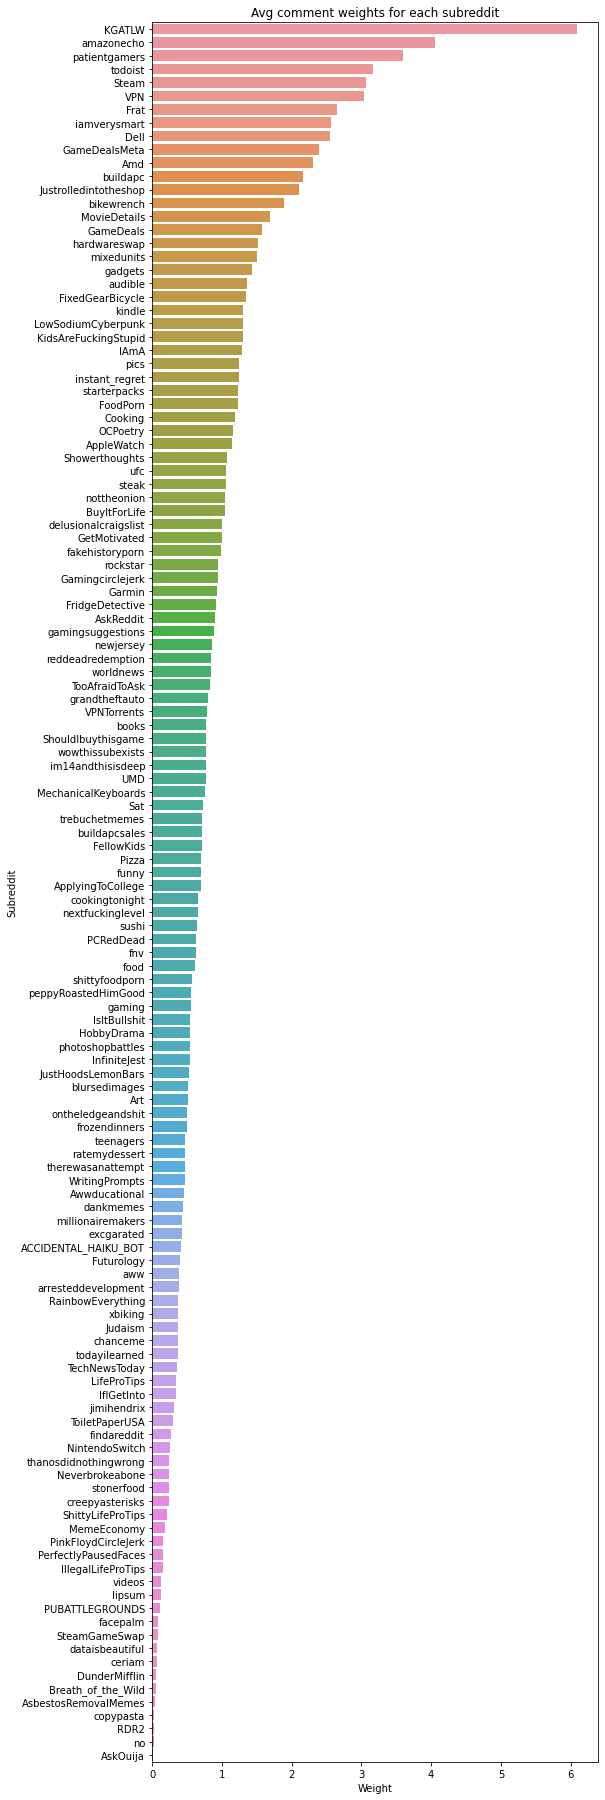

In [11]:
# print avg length_weight for each subreddit

subs_comment_weights = {}
subs_comment_weights = defaultdict(lambda: 0, subs_comment_weights)
for k in subreddits:
    sub_df = one_comment_df[one_comment_df.subreddit == k]
    subs_comment_weights[k] = sub_df['length_weight'].mean()

# {l: v for k,v in sorted(subs_comment_weights.items(), key=lambda item: item[1])}
sorted_comment_weights = sorted(subs_comment_weights.items(), key=lambda x: x[1], reverse=True)
    
x = []
y = []
for k, v in sorted_comment_weights:
    x.append(k)
    y.append(v)

plt.figure(figsize=(8,32))
sns.barplot(x=y, y=x)
plt.title('Avg comment weights for each subreddit')
plt.xlabel('Weight')
plt.ylabel('Subreddit')
plt.show()

If we compare the shape of this graph with the previous graph, it's easy to ensure that a linear relationship was maintained from comment length to comment weight for each subreddit.

### 2.3 Weighting system based off comment age
Naturally, users interests in topics decay over time. Thinking about things that you found interesting one year ago. Then three years ago. Then five years ago. Our interests naturally shift over time. Therefore, it would be apt for my model to reflect this.
 
Let's assume that a redditor's interest in a given topic declines proportinally to the time that has passed since they made the comment. After three years, let's say that their interest in a given topic has decayed by half. In other words, let's create a half life of interest. This 3 year time period might seem somewhat contrived but I think it's necessary for US not to let comment interests decay too much in my model. While people may lose active interest in old hobbies, they may find themselves interested to talk about them when someone brings them up even if it has been quite some time. 

In [17]:
# # weight comments by age
# # Assume interest decays by half in a period of 3 years
INTEREST_HALF_LIFE = 94670778 # 3 years

# create new column
one_comment_df['age_weight'] = [None] * len(one_comment_df)

# get current time
current_time = time.time()

# for i, r in one_comment_df.iterrows():
#     time_diff = current_time - r['created_utc']

#     if time_diff > INTEREST_HALF_LIFE:
#         one_comment_df.at[i, 'age_weight'] = .5
#     else:
#         one_comment_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

In [18]:
age = current_time - user_one_creation

for i, r in one_comment_df.iterrows():
    time_diff = current_time - r['created_utc']

    one_comment_df.at[i, 'age_weight'] = 1 - np.log(time_diff / age)


In [19]:
one_comment_df.tail()

,body,body_length,subreddit,created_utc,date,length_weight,age_weight
430,Reading -2 39\nWriting -2 38\nMath -6 36.5,40,Sat,1.510955e+09,2017-11-17 16:48:40,0.576159,1.248884
431,1500,4,Sat,1.510955e+09,2017-11-17 16:35:34,0.057616,1.248877
432,same,4,Sat,1.510952e+09,2017-11-17 15:50:04,0.057616,1.248852
433,"I did make a fork, and I may post my changes o...",1395,amazonecho,1.480042e+09,2016-11-24 21:46:16,20.093543,1.001338
434,This is awesome: thank you so much for this! \...,152,amazonecho,1.479922e+09,2016-11-23 12:22:28,2.189404,1.000485


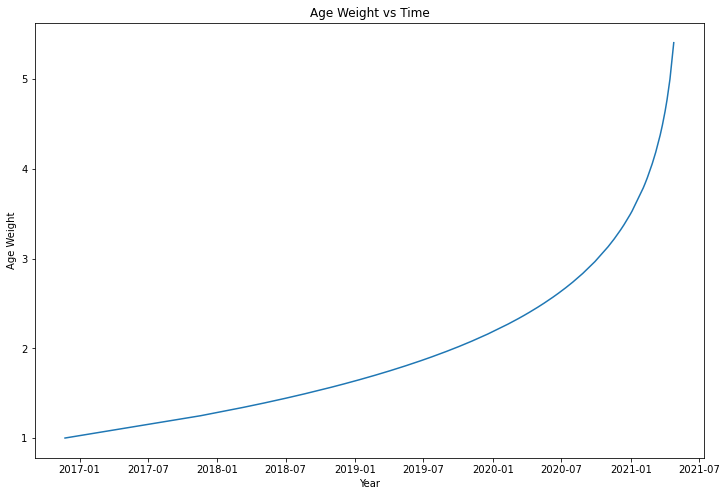

In [20]:
plt.figure(figsize=(12,8))
plt.plot(one_comment_df['date'], one_comment_df['age_weight'])
plt.title("Age Weight vs Time")
plt.xlabel("Year")
plt.ylabel("Age Weight")
plt.show()

We can see that interest weights reflect how we intended the system to be designed: proportionally falling as time passes, but not ever falling more than half.

### 2.4 User Two
Now, we must repeat both these weighting systems for user two's comments

In [21]:
# get users comments
LIMIT = None
user_two_comments = reddit.redditor(USER_TWO).comments.new(limit=LIMIT)
two_comment_df = pd.DataFrame(columns=['body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for comment in user_two_comments:
    two_comment_df.loc[i] = [comment.body, len(comment.body), comment.subreddit, comment.created_utc]
    i += 1

# comment length weight
two_avg_comment_len = two_comment_df['body_length'].mean()

two_comment_df['length_weight'] = [None] * len(two_comment_df)

for i,r in two_comment_df.iterrows():
    two_comment_df.at[i, 'length_weight'] = r['body_length'] / two_avg_comment_len

# weight comments by age
# create new column
two_comment_df['age_weight'] = [None] * len(two_comment_df)

for i, r in two_comment_df.iterrows():
    time_diff = current_time - r['created_utc']

    if time_diff > INTEREST_HALF_LIFE:
        two_comment_df.at[i, 'age_weight'] = .5
    else:
        two_comment_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

two_comment_df.head()

,body,body_length,subreddit,created_utc,length_weight,age_weight
0,Depends what you mean by Professor.\n\nTechnic...,523,UMD,1.616204e+09,1.312169,0.974595
1,"I find it very demoralizing and, worse, diffic...",186,UMD,1.614618e+09,0.46666,0.966218
2,I actually thought the point was more interest...,368,musictheory,1.612901e+09,0.923285,0.957146
3,"It all seems relatively benign, which just rai...",72,law,1.611119e+09,0.180643,0.947737
4,I’ve always found mutt to be clunky with multi...,199,linux,1.610816e+09,0.499276,0.946134


While user one and user two may exhibit differing average comment lengths, the weighting system will reflect their own personal average length and therefore help to standardize comment length accross the two users.

In [22]:
print(one_avg_comment_len, two_avg_comment_len)

69.42528735632185 398.5768194070081


## 3. Submission data analysis
Comments are not the only way that users publicly express their interest for certain subreddits. In fact, they may not even be even the best metric to reflect publicly displayed interest. There is a famous rule in internet culture known as the 1% rule (https://en.wikipedia.org/wiki/1%25_rule_(Internet_culture)). This rule theorizes that a large majority of the users (90%) on a given platform will only consume content. A smaller subset of users will update and maintain content (9%). Finally, only 1% of users will actually contribute new content.

If we loosely apply this concept to reddit submissions then it should tell us this. 90% of people consume content. 9% of people comment on and moderate content. Only 1% of users submit content. Therefore, submissions -- or posts -- may be an even better metric to reflect subject interest. If a user adds content to a specific topic, it means that they, unprompted, went out of their way to ask a question or share some relevant information.

First, we need to use PRAW to get the user's post history

In [23]:
# get users posts
user_one_posts = reddit.redditor(USER_ONE).submissions.new(limit=LIMIT)
one_post_df = pd.DataFrame(columns=['title', 'body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for post in user_one_posts:
    one_post_df.at[i] = [post.title, post.selftext, len(post.selftext), post.subreddit, post.created_utc]
    i += 1

In [24]:
one_post_df.head()

,title,body,body_length,subreddit,created_utc
0,Sublet in Logan Circle area,I'm looking to sublet a place in the Logan Cir...,178,DCforRent,1617990803.0
1,[Opinion] Dana White should support (and maybe...,This post is not a personal endorsement nor a ...,1696,ufc,1615154939.0
2,First time making smash onion burgers on my ne...,,0,burgers,1612987557.0
3,Got this knife killing a thug in the Day in th...,,0,cyberpunkgame,1609999384.0
4,Got this knife killing a thug in the Day in th...,,0,cyberpunkgame,1609999240.0


### 3.1 Post length weighting
Similarly to the comment weighting, we want to give longer posts greater weight. A longer post represents more effort in contributing to the dicussion of a topic, and therefore more interest.

In [25]:
subreddits = {}
subreddits = defaultdict(lambda: [0, 0], subreddits)

# get average post length for each subreddit
for i, r in one_post_df.iterrows():
    sub = str(r['subreddit'])
    subreddits[sub] = [subreddits[sub][0] + r['body_length'], subreddits[sub][1] + 1]

for sub in subreddits:
    subreddits[sub] = subreddits[sub][0] / subreddits[sub][1]

subreddits_sorted_one = sorted(subreddits.items(), key=lambda x: x[1])
print(subreddits_sorted_one)

[('burgers', 0.0), ('cyberpunkgame', 0.0), ('JustHoodsLemonBars', 0.0), ('AskReddit', 0.0), ('im14andthisisdeep', 0.0), ('FellowKids', 0.0), ('smashbros', 0.0), ('torrents', 9.0), ('FixedGearBicycle', 9.0), ('DCforRent', 178.0), ('copypasta', 247.0), ('ShouldIbuythisgame', 266.0), ('Sat', 347.0), ('buildapc', 629.0), ('Dell', 656.0), ('GameDealsMeta', 695.0), ('VPNTorrents', 887.0), ('bikewrench', 954.0), ('AppleWatch', 961.0), ('VPN', 1096.0), ('ufc', 1696.0)]


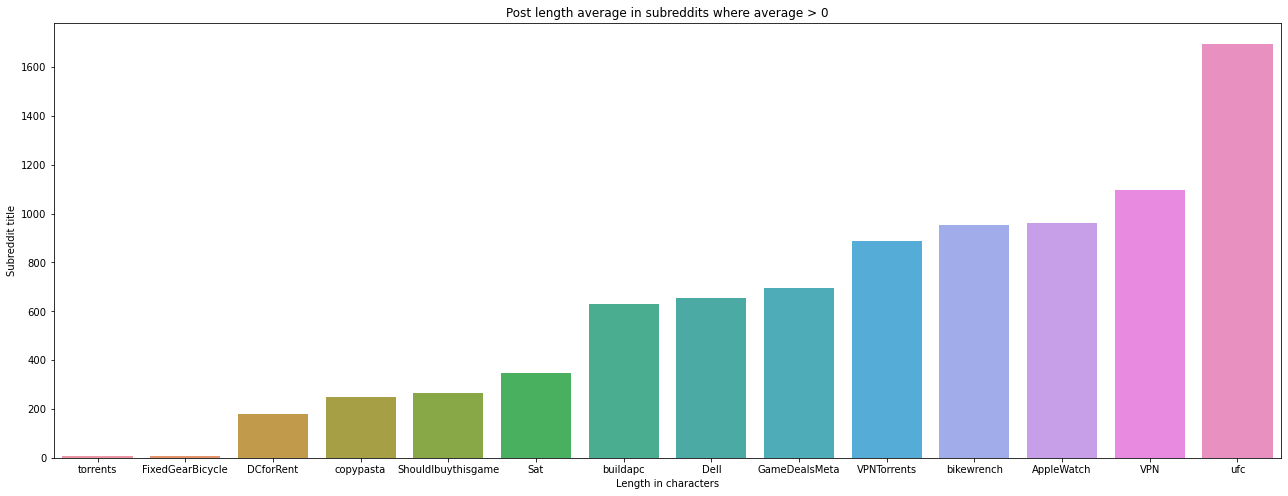

In [26]:
sub_keys = []
sub_vals = []
for k, v in subreddits_sorted_one:
    if v != 0:
        sub_keys.append(k)
        sub_vals.append(v)

plt.figure(figsize=(22,8))
sns.barplot(x=sub_keys, y=sub_vals)
plt.title("Post length average in subreddits where average > 0")
plt.xlabel("Length in characters")
plt.ylabel("Subreddit title")
plt.show()

This shows us average post length in subreddits where that length is non zero. This should give us a pretty good perspective on what the average post length is going to be. Let's find out what that is below.

In [27]:
# find overall post length average for user one
one_post_average = one_post_df['body_length'].mean()
print(one_post_average)

402.5652173913044


Now, let's create a weighting system based on this average post length for subreddits. We want the weight of a post's body length to be proportional to the user's overall post length average. This should produce a weight with a linear relationship.

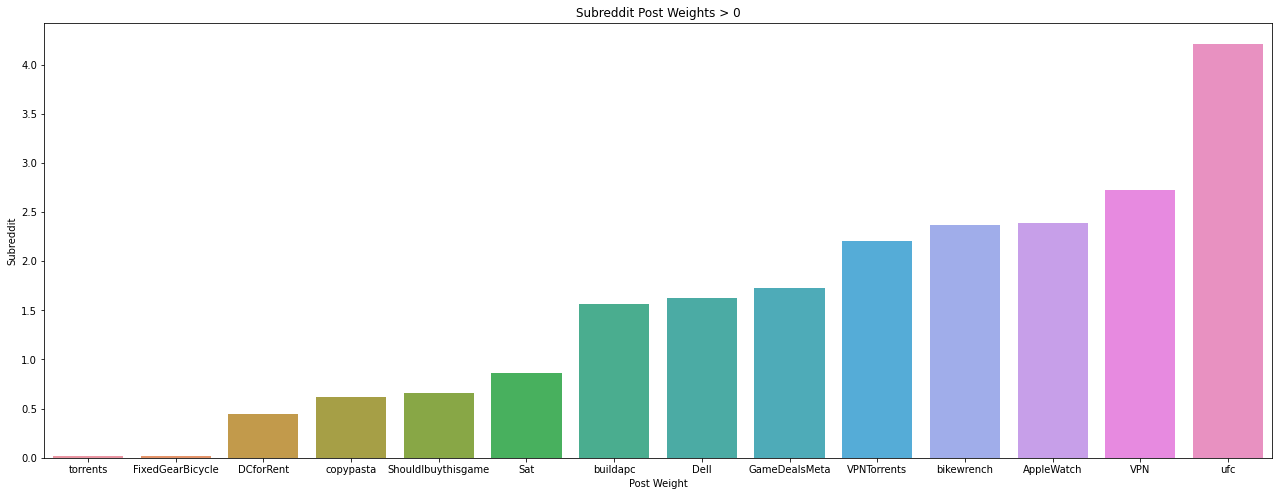

In [28]:
# create weights for post length compared to average for user one
one_post_df['length_weight'] = [None] * len(one_post_df)

for i, r in one_post_df.iterrows():
    r['length_weight'] = r['body_length'] / one_post_average

# graph weights for each subreddit
subreddit_post_weights = {}
subreddit_post_weights = defaultdict(lambda: 0, subreddit_post_weights)
for sub in subreddits.keys():
    curr = one_post_df[one_post_df.subreddit == sub]
    subreddit_post_weights[sub] = curr['length_weight'].mean()

subreddit_post_weights = sorted(subreddit_post_weights.items(), key=lambda x: x[1])

sub_keys = []
sub_vals = []
for k, v in subreddit_post_weights:
    if v != 0:
        sub_keys.append(k)
        sub_vals.append(v)

plt.figure(figsize=(22,8))
sns.barplot(x=sub_keys, y=sub_vals)
plt.title("Subreddit Post Weights > 0")
plt.xlabel("Post Weight")
plt.ylabel("Subreddit")
plt.show()

As we can see the post weights for subreddits accurately reflect the average post lengths of given subreddits. This relationship is preserved.

### 3.2 Elapsed time since posting weighting
Lets consider how interest in submission topics decays over time. Lets do something similar to what we did for the comments.

In [29]:
# weight posts by age
# create new column
one_post_df['age_weight'] = [None] * len(one_post_df)

# get current time
current_time = time.time()

# for i, r in one_post_df.iterrows():
#     time_diff = current_time - r['created_utc']

#     if time_diff > INTEREST_HALF_LIFE:
#         one_post_df.at[i, 'age_weight'] = .5
#     else:
#         one_post_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

age = current_time - user_one_creation

for i, r in one_post_df.iterrows():
    time_diff = current_time - r['created_utc']

    one_post_df.at[i, 'age_weight'] = 1 - np.log(time_diff / age)

one_post_df.tail()

,title,body,body_length,subreddit,created_utc,length_weight,age_weight
18,[XPS 9360] Trackpad feels stiff and hard to cl...,Today I just got my XPS 9360 back from repairs...,656,Dell,1531961222.0,1.62955,1.460667
19,RAM and SSD preforming way below expectations?,I recently purchased a GTX 980Ti to replace my...,871,buildapc,1530670326.0,2.163625,1.446276
20,EVGA midweek madness sales help?,"Hi, a friend recently told me about the EVGA m...",387,buildapc,1529895739.0,0.961335,1.437738
21,Apple watch S2 vs S3 vs S4?,"I currently have the Apple watch sport S0, and...",961,AppleWatch,1528856104.0,2.387191,1.426393
22,Should I cancel my test?,I accidentally forgot to do all five of the gr...,347,Sat,1520711674.0,0.861972,1.341708


Add human comprehensible Julian calendar dates based on the epoch time stamps for posts. This will allow for ease of interperetation in graphs.

In [30]:
# add date column
one_post_df['date'] = [None] * len(one_post_df)

# add standard date
for i,r in one_post_df.iterrows():
    one_post_df.at[i, 'date'] = datetime.datetime.fromtimestamp(r['created_utc'])

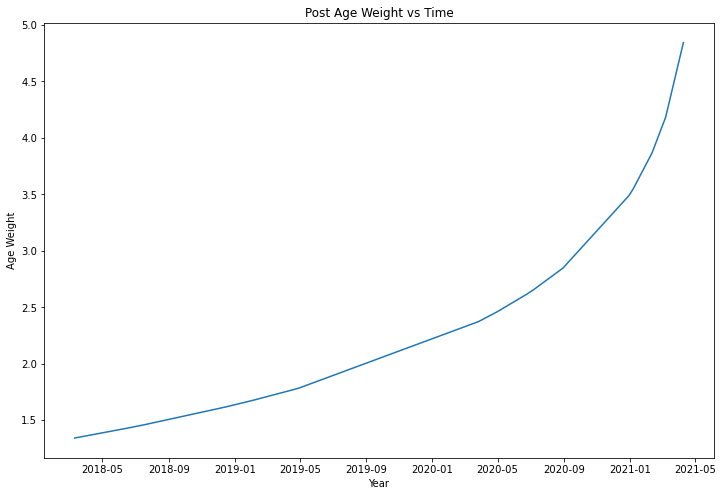

In [31]:
plt.figure(figsize=(12,8))
plt.plot(one_post_df['date'], one_post_df['age_weight'])
plt.title("Post Age Weight vs Time")
plt.xlabel("Year")
plt.ylabel("Age Weight")
plt.show()

This graph reflects what the intended look for age weighting should be. All is good.

### 3.3 Repeat for user 2

In [32]:
# get users posts
user_two_posts = reddit.redditor(USER_TWO).submissions.new(limit=LIMIT)
two_post_df = pd.DataFrame(columns=['title', 'body', 'body_length', 'subreddit', 'created_utc'])

i = 0
for post in user_two_posts:
    two_post_df.at[i] = [post.title, post.selftext, len(post.selftext), post.subreddit, post.created_utc]
    i += 1

# comment length weight
two_avg_post_len = two_post_df['body_length'].mean()

two_post_df['length_weight'] = [None] * len(two_post_df)

for i,r in two_post_df.iterrows():
    two_post_df.at[i, 'length_weight'] = r['body_length'] / two_avg_post_len

# weight comments by age
# create new column
two_post_df['age_weight'] = [None] * len(two_post_df)

for i, r in two_post_df.iterrows():
    time_diff = current_time - r['created_utc']

    if time_diff > INTEREST_HALF_LIFE:
        two_post_df.at[i, 'age_weight'] = .5
    else:
        two_post_df.at[i, 'age_weight'] = 1 - (time_diff / (INTEREST_HALF_LIFE * 2)) 

two_post_df.head()

,title,body,body_length,subreddit,created_utc,length_weight,age_weight
0,Trump issues new Executive Order relating to t...,,0,law,1611117391.0,0.0,0.947728
1,"Any insight into Joe Pass's approach to ""Let i...","Hey all,\n\nI've been transcribing Joe Pass's ...",1131,jazzguitar,1607068195.0,6.437799,0.926342
2,What About the Natural Numbers? PWLConf 2019 [...,,0,programming,1569334557.0,0.0,0.727054
3,Hoping for constructive criticism and advice o...,,0,apexlegends,1558804572.0,0.0,0.67144
4,ICFP 2018 Accepted (or conditionally accepted)...,,0,haskell,1526573893.0,0.0,0.501215


## 4. Subreddit Weighting Factors
Now that we've considered weighting factors related individually to comments or submissions, we want to consider what factors relate to subreddits as a whole. There are two factors we want to pursue in this section. First, how long a user has been interested in a specific topic/subreddit, and second, how 'niche' is that interest?

### 4.1 Subreddit interest duration
Another factor we want to consider when trying to quanitfy a redditor's interest in a given subreddit is the duration of their interest. In other words, how much time has elapsed since their first post or submission and their most recent post and submission? We can then compare this to the redditor's total duration of time spent on the platform. In this way, we can characterize what a redditor's long term interests are -- at least on the platform -- and what may be potentially an ephemeral interest. Another added benefit of this is to restore some of the weighting lost for older posts and comments if they belong to an interest that the redditor has spent considerable time engaged in.

First, let's create a function that will allow us to get the 'head' of our dictionaries. This will prove useful in this next section, as well as following sections.

In [33]:
def glance(mydict):
    return dict(list(mydict.items())[:5])

def glance_tail(mydict):
    return dict(list(mydict.items())[-5:])

In [34]:
# comments/posts interest age
subreddits_interest_one = defaultdict(lambda: [current_time, 0])

# find oldest and most recent comments for each subreddit
for i, r in one_comment_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_one[sub][0]:
        subreddits_interest_one[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_one[sub][1]:
        subreddits_interest_one[sub][1] = r['created_utc']

print(glance(subreddits_interest_one))
print(glance_tail(subreddits_interest_one))


{'OCPoetry': [1619288966.0, 1619288966.0], 'UMD': [1554567506.0, 1619273825.0], 'kindle': [1617305643.0, 1618534792.0], 'newjersey': [1604262649.0, 1618422843.0], 'audible': [1617930708.0, 1617931251.0]}
{'grandtheftauto': [1531629285.0, 1531673564.0], 'Sat': [1510951804.0, 1531308236.0], 'excgarated': [1530509288.0, 1530509288.0], 'nottheonion': [1528942709.0, 1528942709.0], 'LifeProTips': [1528082800.0, 1528082800.0]}


Here are the times of the first and last comment by a user for each subreddit they have commented on. These are in epoch time for ease of calculations.

In [35]:
# find the oldest and most recent submissions for each subreddit, replacing the timestamp for the comments if older/more recent respectively
for i, r in one_post_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_one[sub][0]:
        subreddits_interest_one[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_one[sub][1]:
        subreddits_interest_one[sub][1] = r['created_utc']

print(glance(subreddits_interest_one))
print(glance_tail(subreddits_interest_one))

{'OCPoetry': [1619288966.0, 1619288966.0], 'UMD': [1554567506.0, 1619273825.0], 'kindle': [1617305643.0, 1618534792.0], 'newjersey': [1604262649.0, 1618422843.0], 'audible': [1617930708.0, 1617931251.0]}
{'DCforRent': [1617990803.0, 1617990803.0], 'burgers': [1612987557.0, 1612987557.0], 'cyberpunkgame': [1609999240.0, 1609999384.0], 'torrents': [1609298621.0, 1609298621.0], 'smashbros': [1544919094.0, 1544919094.0]}


Now, we have also examined submission times. If there is an older submission or more recent subreddit than comment in a certain subreddit, the dates have been replaced accordingly. If there are any subreddits that have been posted on but not commented on these have been added.

In [36]:
# calculate the difference in time in order to get interest length
for k in subreddits_interest_one:
    v = subreddits_interest_one[k]
    subreddits_interest_one[k] = v[1] - v[0]

print(glance(subreddits_interest_one))
print(glance_tail(subreddits_interest_one))

{'OCPoetry': 0.0, 'UMD': 64706319.0, 'kindle': 1229149.0, 'newjersey': 14160194.0, 'audible': 543.0}
{'DCforRent': 0.0, 'burgers': 0.0, 'cyberpunkgame': 144.0, 'torrents': 0.0, 'smashbros': 0.0}


Now, we want to go through and calculate the difference in the latest and oldest interaction with each subreddit on this list. This difference in time represents the elapsed time of interest in each given subreddit. Many of the subreddits a user interacts with will be a one time deal, and the multitude of zeroes in this list reflect that.

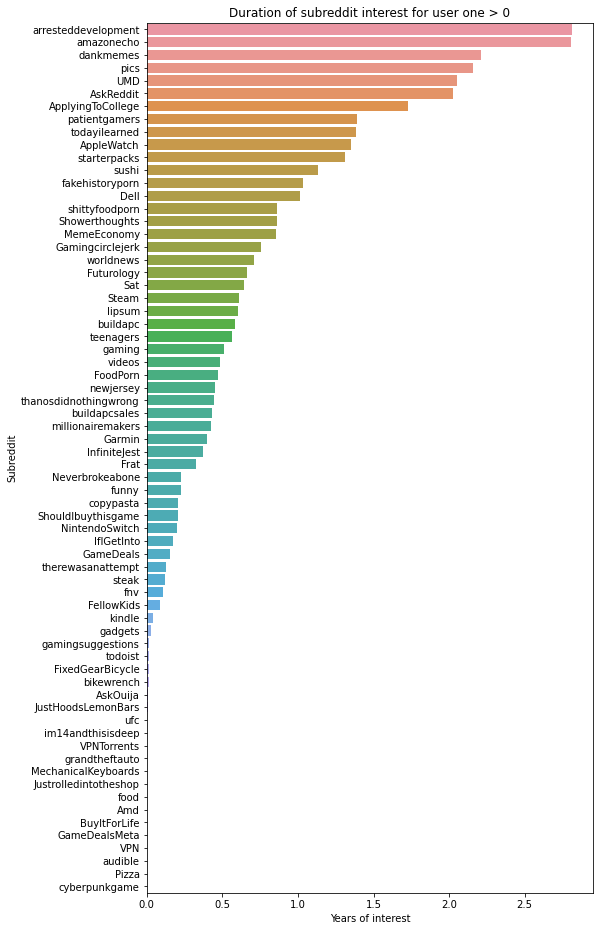

In [37]:
# sort and graph this
subreddits_interest_one_sorted = sorted(subreddits_interest_one.items(), key=lambda x: x[1], reverse=True)

keys = []
vals = []
for k, v in subreddits_interest_one_sorted:
    if v != 0:
        keys.append(k)
        vals.append(v / 3.154e+7)

plt.figure(figsize=(8,16))
sns.barplot(y=keys, x=vals)
plt.title("Duration of subreddit interest for user one > 0")
plt.xlabel("Years of interest")
plt.ylabel("Subreddit")
plt.show()

This is a graphical representation of the total years of interest user one has in each subreddit. It should show us what about the average should be, and the shape of the weighting system should match this graph.

### 4.2 Subreddit interest duration weight.
Now, we want to create a weighting system for this. Let's create weights as a proportion of subreddit interest duration relative to average interest duration. While this could be as a proportion relative to total account age, I see an issue with this. Consider a redditor with a short attention span. They may be just as interested in certain topics (for the point of this project) as someone with a longer attention span, but the duration of that interest may represent a smaller period of their total activity timne on reddit.

In [38]:
# First, we must calculate the average duration of user one's interest in subreddits (in seconds)
one_interest_average = 0

for k, v in subreddits_interest_one_sorted:
    one_interest_average += v

one_interest_average /= len(subreddits_interest_one_sorted)

print(one_interest_average)

8971520.518518519


We must calculate the average duration of the user's interest in any subreddit. Weights will be proportional to this average value.

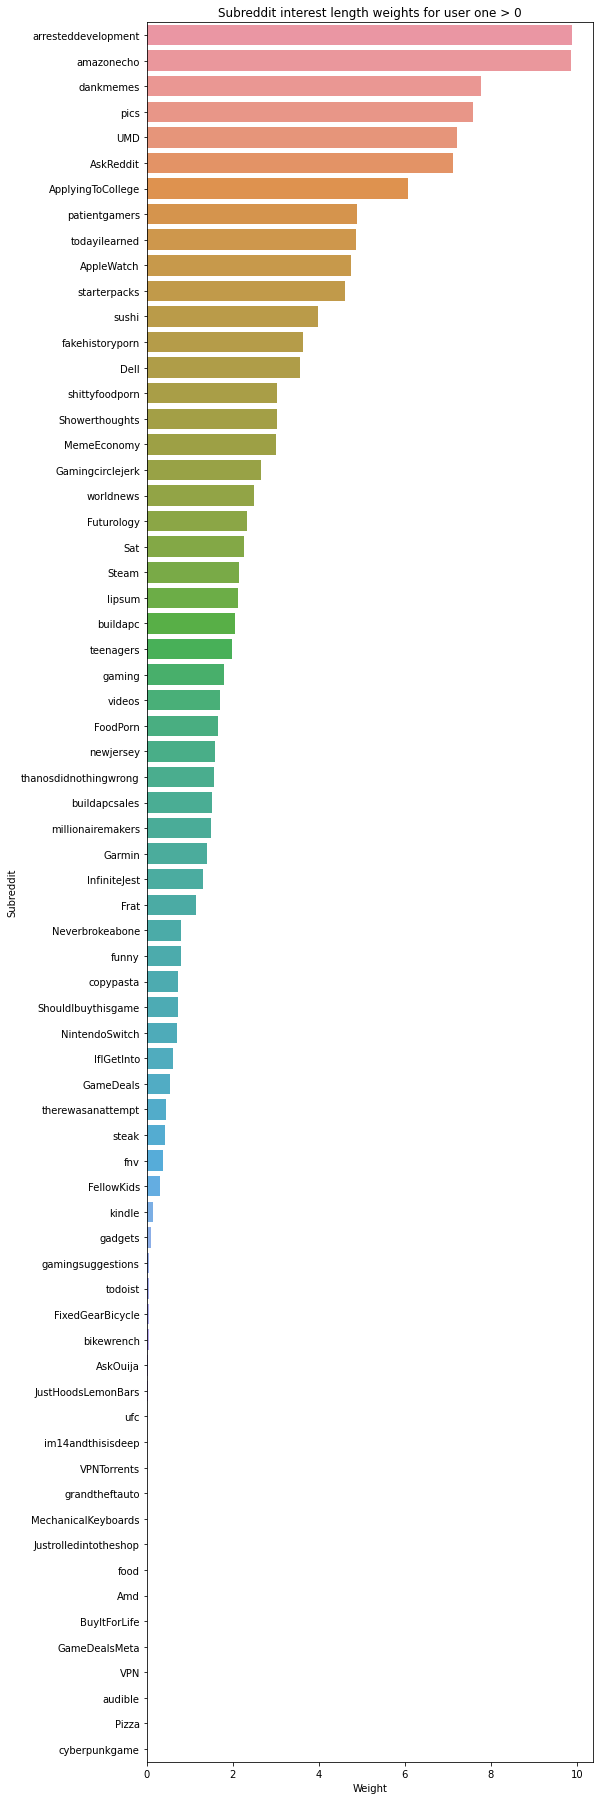

In [39]:
subreddits_interest_one_weights = defaultdict(lambda: 0)

for k, v in subreddits_interest_one_sorted:
    subreddits_interest_one_weights[k] = v / one_interest_average

keys = []
vals = []
for k in subreddits_interest_one_weights:
    v = subreddits_interest_one_weights[k]
    if v != 0:
        keys.append(k)
        vals.append(v)

plt.figure(figsize=(8,32))
sns.barplot(y=keys, x=vals)
plt.title("Subreddit interest length weights for user one > 0")
plt.xlabel("Weight")
plt.ylabel("Subreddit")
plt.show()

As we can see, the shape of the graph matches up with the shape of the duration graph. This means that our weight should maintain a linear relationship.

### 4.3 Repeat calculations for user 2

In [40]:
# comments/posts interest age
subreddits_interest_two = defaultdict(lambda: [current_time, 0])

# find oldest and most recent comments for each subreddit
for i, r in two_comment_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_two[sub][0]:
        subreddits_interest_two[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_two[sub][1]:
        subreddits_interest_two[sub][1] = r['created_utc']

# find the oldest and most recent submissions for each subreddit, replacing the timestamp for the comments if older/more recent respectively
for i, r in two_post_df.iterrows():
    sub = str(r['subreddit'])

    if r['created_utc'] < subreddits_interest_two[sub][0]:
        subreddits_interest_two[sub][0] = r['created_utc']
    
    if r['created_utc'] > subreddits_interest_two[sub][1]:
        subreddits_interest_two[sub][1] = r['created_utc']

# calculate the difference in time in order to get interest length
for k in subreddits_interest_two:
    v = subreddits_interest_two[k]
    subreddits_interest_two[k] = v[1] - v[0]

# create the weighting system
two_interest_average = 0
for k in subreddits_interest_two:
    v = subreddits_interest_two[k]
    two_interest_average += v
two_interest_average /= len(subreddits_interest_two)

subreddits_interest_two_weights = defaultdict(lambda: 0)
for k in subreddits_interest_two:
    v = subreddits_interest_two[k]
    subreddits_interest_two_weights[k] = v / one_interest_average


### 4.4 Calculate subreddit size weights
One additional measure we can use to weight user subreddit interest is to factor in subreddit size. Redditors can be expected to share subscriptions and therefore potentially interactions such as comments and submissions in the "default" subreddits. (I put it in quotes because the default nature of these may have changed in reddit updates, but they are still some of the most popular subreddits). Furthermore, while not a comprehensive rule, it might be reasonable to make an assumption here. Larger subreddits generally represent more general interests. Subreddits like r/funny, r/news, r/Music all represent very broad interest categories. For each of these subreddits there are smaller, more niche topic subreddits, that therefore represent more unique interests. If two users share a less-common interest, then we would like to add particular weight to that shared interest.

Let's start our calculations with user one. First, let's grab the subreddit subscriber count for each subreddit the user is subscribed to (as captured by the interest dict).

In [41]:
one_subreddit_sizes = defaultdict(lambda: 0)
for k, v in subreddits_interest_one_sorted:
    subs = reddit.subreddit(str(k)).subscribers
    one_subreddit_sizes[k] = subs


C:\Users\ariqb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


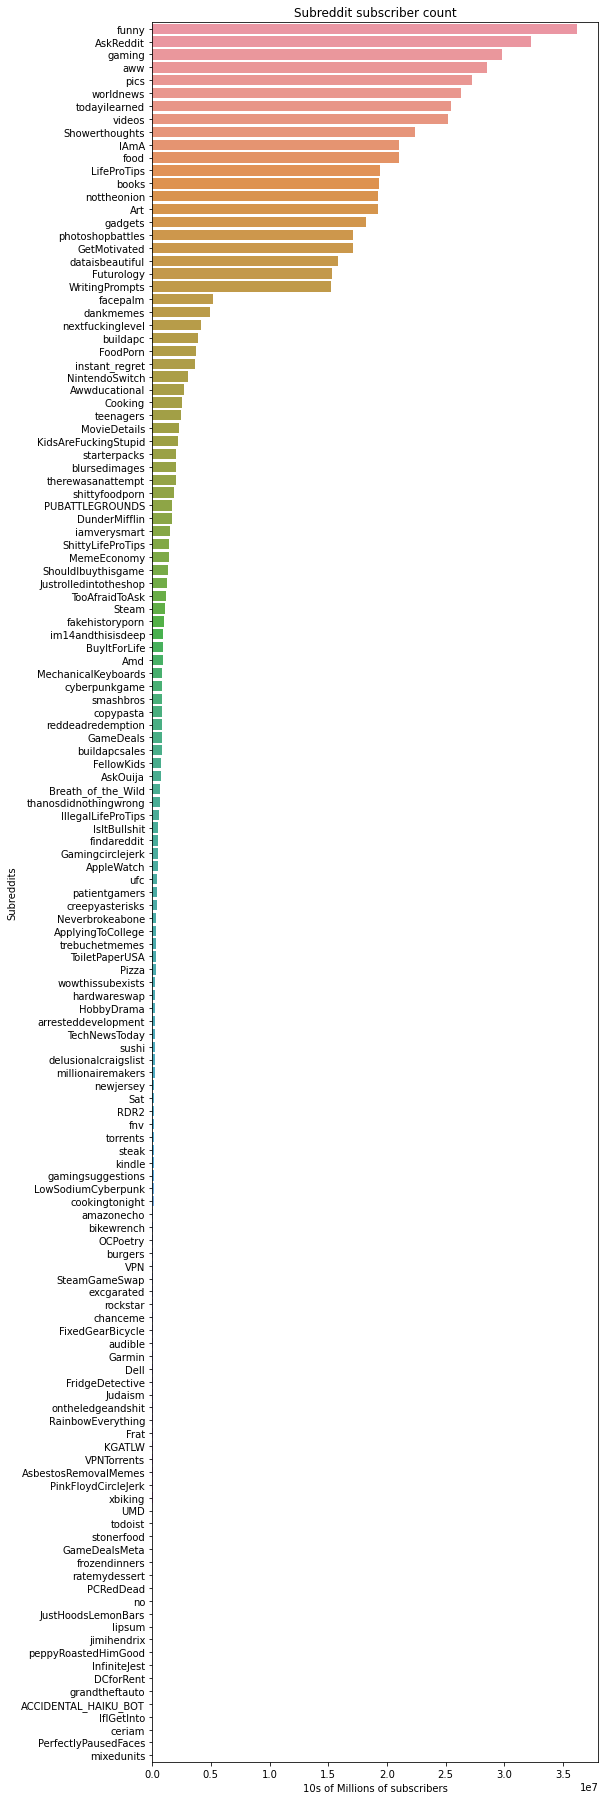

In [42]:
one_sub_sizes_sorted = sorted(one_subreddit_sizes.items(), key=lambda x: x[1], reverse=True)

x = []
y = []
for k, v in one_sub_sizes_sorted:
    x.append(k)
    y.append(v)

plt.figure(figsize=(8,32))
sns.barplot(y, x)
plt.title("Subreddit subscriber count")
plt.xlabel('10s of Millions of subscribers')
plt.ylabel('Subreddits')
plt.show()


This graph shows us that subreddits have a large variety in size. The evolution of subreddit sizes, furthermore, seems to better fit an exponential than a linear model. In order to create a weighting system for each subreddit, I think we should account for this. Ideally, I would like to create a linear weighting system that reflects this data proprely.

If I attempt to create weights in proportion to the average subreddit size, similar to what I have done to past models, I think this will produce a weighting system that doesn't accurately model what I want. Let me calculate the average to demonstrate this.

In [43]:
avg_sub_size_one = 0
for k, v in one_sub_sizes_sorted:
    avg_sub_size_one += v
avg_sub_size_one /= len(one_sub_sizes_sorted)

print(avg_sub_size_one)

4124124.8814814813


The average subreddit size in this case hovers around 4 million people. Let's consider a subreddit with 1000 subscribers. 4 million / 1000 produces a weight of 4000. Is a subreddit with 1000 subscribers 4000x more niche than the 'average' subreddit for this user? Maybe in some cases, but for the most case probably not.

To account for the exponential data, let's find the natural log of the number of subscribers for each subreddit. This should help to 'linearize' the graph.

I will use 1 + log(x) for my function in order to avoid divide by zero errors when I take the natural log of a 1 subscriber subreddit. (Cough: r/jmct)

C:\Users\ariqb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


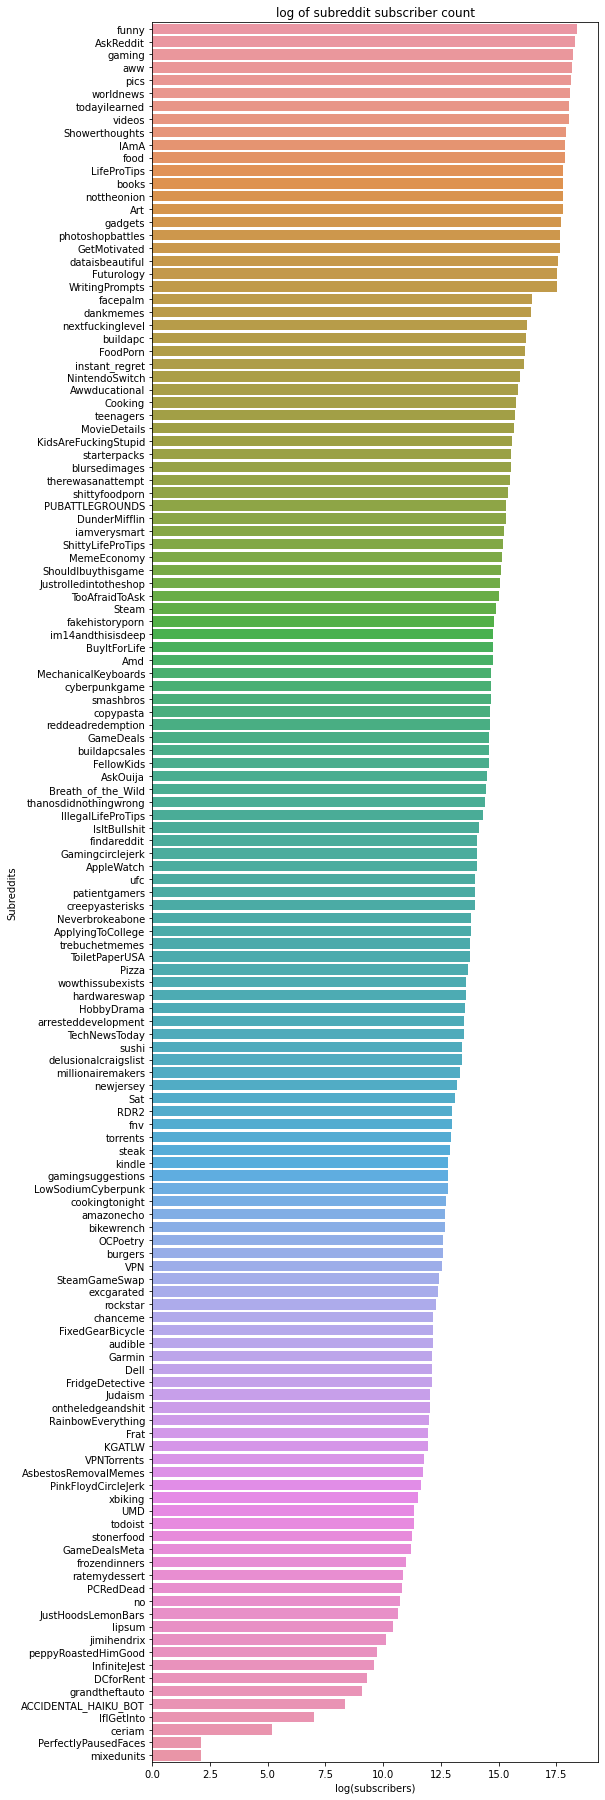

In [44]:
sub_one_log = copy.deepcopy(dict(one_sub_sizes_sorted))

for k in sub_one_log:
    v = sub_one_log[k]
    sub_one_log[k] = 1 + np.log(v)

x = []
y = []
for k in sub_one_log:
    v = sub_one_log[k]
    x.append(k)
    y.append(v)

plt.figure(figsize=(8,32))
sns.barplot(y, x)
plt.title("log of subreddit subscriber count")
plt.xlabel('log(subscribers)')
plt.ylabel('Subreddits')
plt.show()

Now, we should find a more satisfactory mean:

In [45]:
x = []
for k in sub_one_log:
    v = sub_one_log[k]
    x.append(v)

mean_sub_size_one = np.mean(x)
print(mean_sub_size_one)

13.8231678524893


Let's now calculate the weights for these. We need to consider that a lower log value actually represents a higher interest. Therefore we can divide the mean by the value we are testing instead of the opposite way around.

{'funny': 0.7510736427160402, 'AskReddit': 0.7557932670388371, 'gaming': 0.7591046581297978, 'aww': 0.7608893349375714, 'pics': 0.7628345333274101}
{'ACCIDENTAL_HAIKU_BOT': 1.655366874099875, 'IfIGetInto': 1.9715648410822448, 'ceriam': 2.6714598524373887, 'PerfectlyPausedFaces': 6.586813546804404, 'mixedunits': 6.586813546804404}
C:\Users\ariqb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


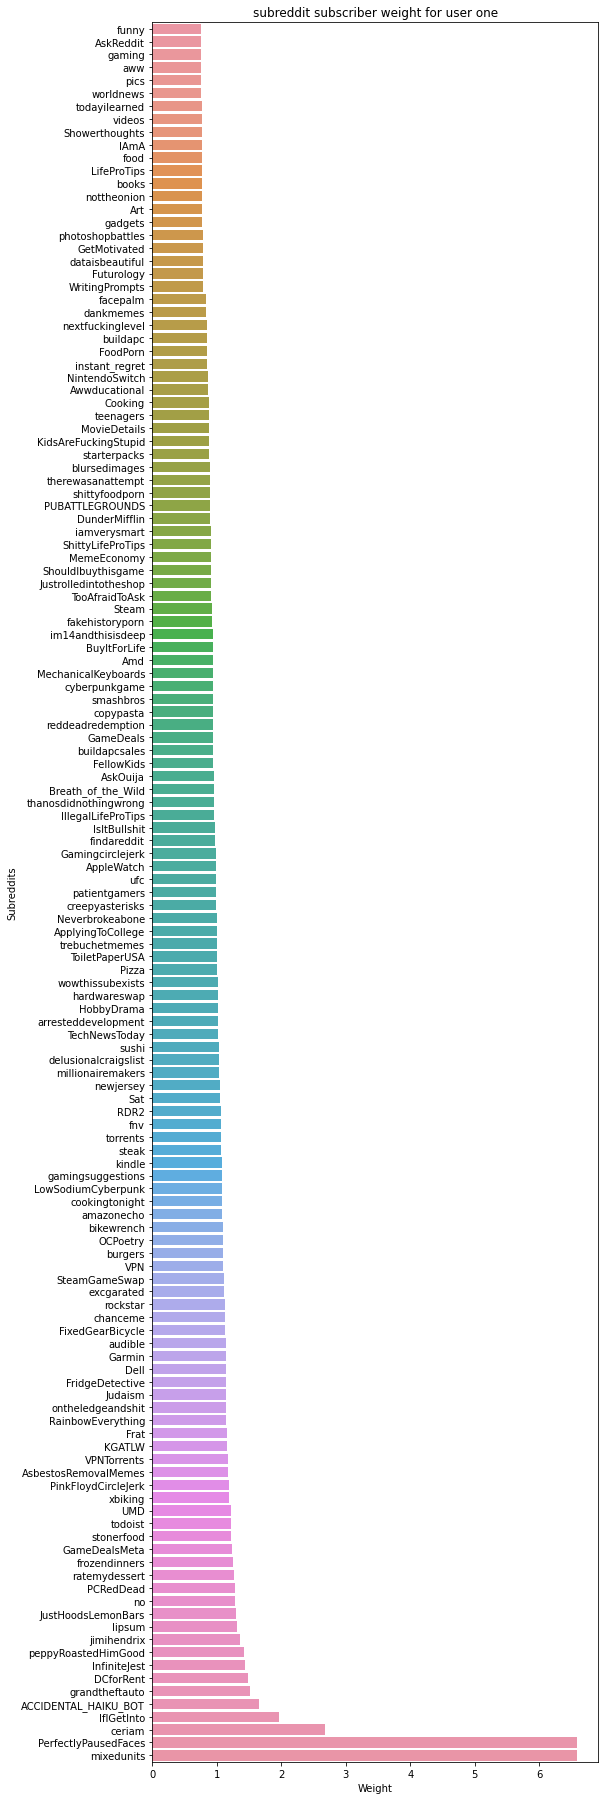

In [46]:
one_niche = defaultdict(lambda: 0)

for k in sub_one_log:
    one_niche[k] = mean_sub_size_one / sub_one_log[k]

print(glance(one_niche))
print(glance_tail(one_niche))

x = list(one_niche.keys())
y = list(one_niche.values())

plt.figure(figsize=(8,32))
sns.barplot(y, x)
plt.title("subreddit subscriber weight for user one")
plt.xlabel('Weight')
plt.ylabel('Subreddits')
plt.show()

Let's prune some outliers. Looking at this graph, anything weighted over 2 will be calculated to have a much greater 'nicheness' factor compared to the rest of the graph. Let's correct for this, and instead of just dropping the outliers, let's adjust any weight over 2 to be equal to 2 in order to not effect calculations down the line in an unintended way.

In [47]:
for k in one_niche:
    if one_niche[k] > 2:
        one_niche[k] = 2

C:\Users\ariqb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


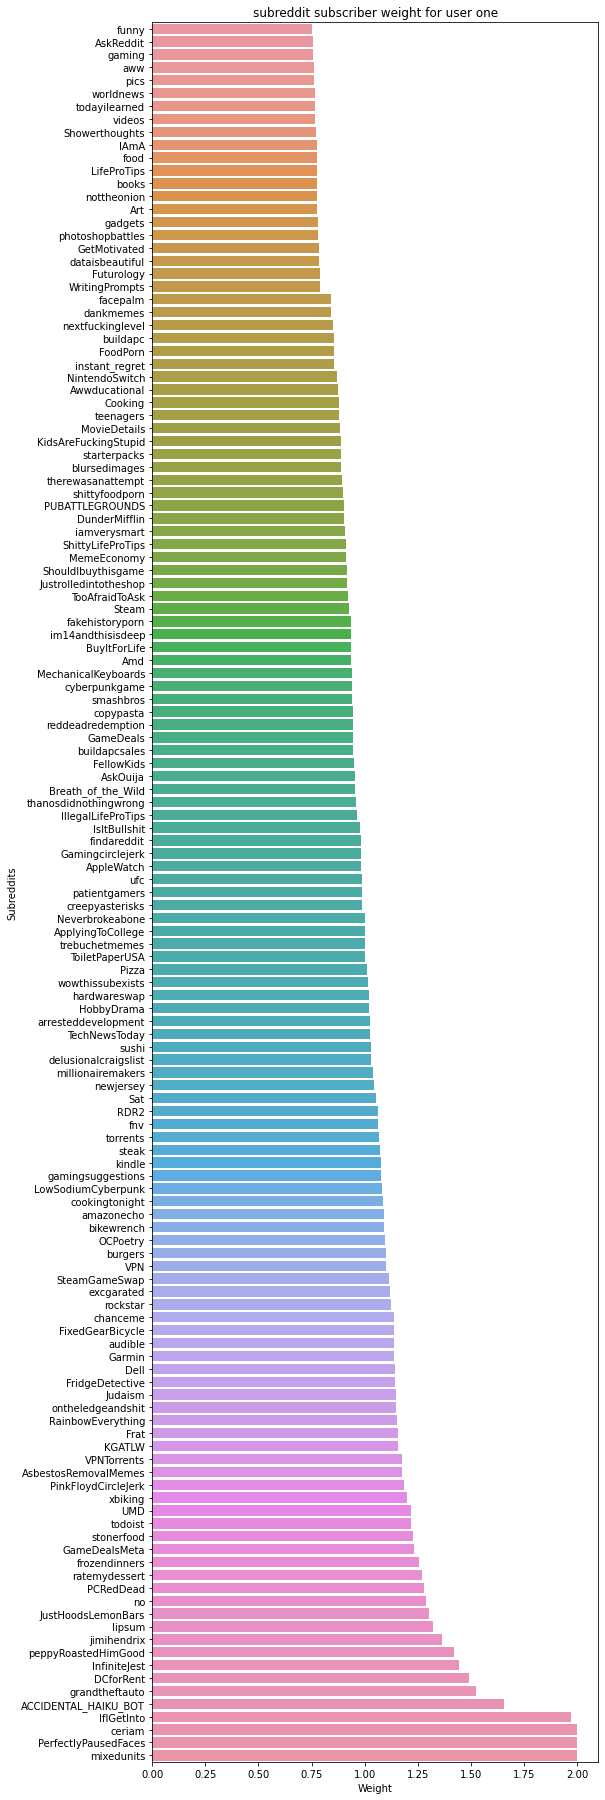

In [48]:
plt.figure(figsize=(8,32))
sns.barplot(list(one_niche.values()), list(one_niche.keys()))
plt.title("subreddit subscriber weight for user one")
plt.xlabel('Weight')
plt.ylabel('Subreddits')
plt.show()

This should be more acceptable for the sake of my calculations down the line.

### 4.4 Repeat for user 2

C:\Users\ariqb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


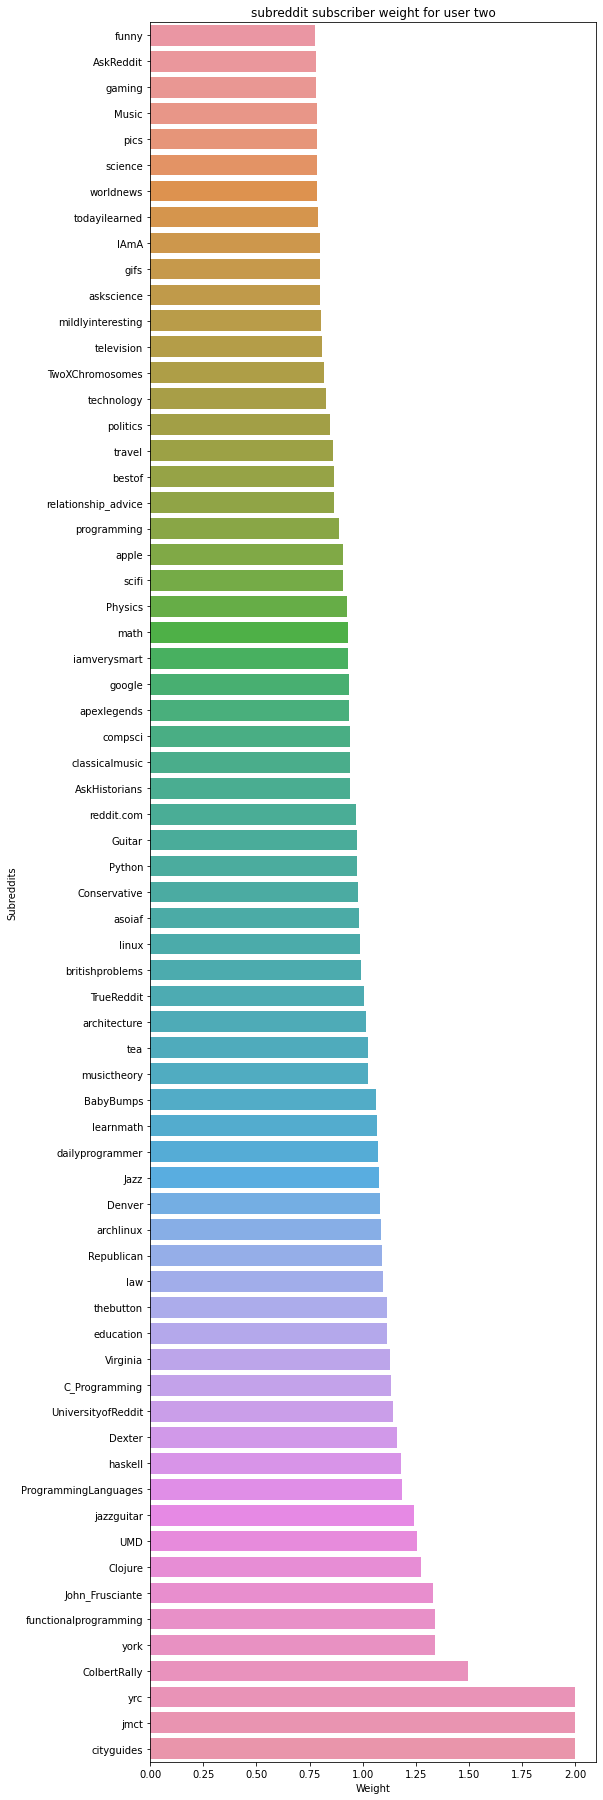

In [49]:
# get subreddit sizes
two_subreddit_sizes = defaultdict(lambda: 0)
for k in subreddits_interest_two:
    subs = reddit.subreddit(str(k)).subscribers
    two_subreddit_sizes[k] = subs

# calculate logs
sub_two_log = defaultdict(lambda: 0)
for k in two_subreddit_sizes:
    v = two_subreddit_sizes[k]
    sub_two_log[k] = 1 + np.log(float(v))
    # sub_two_log[k] = v
# calc mean
x = []
for k in sub_two_log:
    v = sub_two_log[k]
    x.append(v)

mean_sub_size_two = np.mean(x)

# calc weights
two_niche = defaultdict(lambda: 0)

for k in sub_two_log:
    weight = mean_sub_size_two / sub_two_log[k]
    if weight > 2:
        weight = 2
    two_niche[k] = weight

two_niche_sorted = sorted(two_niche.items(), key=lambda x: x[1])

# graph
x = []
y = []
for k, v in two_niche_sorted:
    x.append(k)
    y.append(v)

plt.figure(figsize=(8,32))
sns.barplot(y, x)
plt.title("subreddit subscriber weight for user two")
plt.xlabel('Weight')
plt.ylabel('Subreddits')
plt.show()

### 5.1 Reshaping data
First, let's re-examine what the fruits of our data wrangling so far have been. Then, let's ensure that our data is in the most accessible format.

In [50]:
two_comment_df.head()

,body,body_length,subreddit,created_utc,length_weight,age_weight
0,Depends what you mean by Professor.\n\nTechnic...,523,UMD,1.616204e+09,1.312169,0.974595
1,"I find it very demoralizing and, worse, diffic...",186,UMD,1.614618e+09,0.46666,0.966218
2,I actually thought the point was more interest...,368,musictheory,1.612901e+09,0.923285,0.957146
3,"It all seems relatively benign, which just rai...",72,law,1.611119e+09,0.180643,0.947737
4,I’ve always found mutt to be clunky with multi...,199,linux,1.610816e+09,0.499276,0.946134


In [51]:
two_post_df.head()

,title,body,body_length,subreddit,created_utc,length_weight,age_weight
0,Trump issues new Executive Order relating to t...,,0,law,1611117391.0,0.0,0.947728
1,"Any insight into Joe Pass's approach to ""Let i...","Hey all,\n\nI've been transcribing Joe Pass's ...",1131,jazzguitar,1607068195.0,6.437799,0.926342
2,What About the Natural Numbers? PWLConf 2019 [...,,0,programming,1569334557.0,0.0,0.727054
3,Hoping for constructive criticism and advice o...,,0,apexlegends,1558804572.0,0.0,0.67144
4,ICFP 2018 Accepted (or conditionally accepted)...,,0,haskell,1526573893.0,0.0,0.501215


In [52]:
print(glance(dict(subreddits_interest_one_sorted)))
print(glance_tail(dict(subreddits_interest_one_sorted)))

{'arresteddevelopment': 88713330.0, 'amazonecho': 88418752.0, 'dankmemes': 69821412.0, 'pics': 68107457.0, 'UMD': 64706319.0}
{'LifeProTips': 0.0, 'DCforRent': 0.0, 'burgers': 0.0, 'torrents': 0.0, 'smashbros': 0.0}


In [53]:
print(glance(dict(one_niche)))
print(glance_tail(dict(one_niche)))

{'funny': 0.7510736427160402, 'AskReddit': 0.7557932670388371, 'gaming': 0.7591046581297978, 'aww': 0.7608893349375714, 'pics': 0.7628345333274101}
{'ACCIDENTAL_HAIKU_BOT': 1.655366874099875, 'IfIGetInto': 1.9715648410822448, 'ceriam': 2, 'PerfectlyPausedFaces': 2, 'mixedunits': 2}


Let's place both user's subreddit data inside dataframes instead of inside dictionaries -- this will allow ease of final data processing. We are leaving some empty columns. Iteractions will be filled with what results from the calculations our post and comment weights. We will then make an overall calculation of all of these weights in order to calculate subreddit interest. But that will come later.

In [54]:
one_sub_weights = pd.DataFrame(columns=['subreddit', 'duration', 'niche', 'interactions', 'overall'])
count = 0
for k in dict(subreddits_interest_one_sorted):
    one_sub_weights.loc[count] = [str(k), dict(subreddits_interest_one_weights)[k], dict(one_niche)[k], 0, 0]
    count += 1

one_sub_weights.head()

,subreddit,duration,niche,interactions,overall
0,arresteddevelopment,9.888327,1.023466,0,0
1,amazonecho,9.855492,1.089631,0,0
2,dankmemes,7.782562,0.842567,0,0
3,pics,7.591518,0.762835,0,0
4,UMD,7.212414,1.217261,0,0


In [55]:
two_sub_weights = pd.DataFrame(columns=['subreddit', 'duration', 'niche', 'interactions', 'overall'])
count = 0
for k in dict(two_niche_sorted):
    two_sub_weights.loc[count] = [str(k), dict(subreddits_interest_two_weights)[k], dict(two_niche)[k], 0, 0]
    count += 1

two_sub_weights.head()

,subreddit,duration,niche,interactions,overall
0,funny,15.948732,0.773661,0,0
1,AskReddit,15.943510,0.778523,0,0
2,gaming,0.000005,0.781934,0,0
3,Music,9.061589,0.785608,0,0
4,pics,4.870000,0.785776,0,0


### 5.2 Normalizing Data
In the next step we are going to be combining the weight data we have generated thus far in order to find a weight for each post and submission. We will then use this to generate an interest weight for each subreddit. However, in order to do this we need to make sure each of the weights we are using have the same range. Right now each weighting system is proportional to itself but not proportional to each other. Now, for us to be satisfied with using them in one total calculation, we must change that.

In order to best do this, we really need to scale the data. This will preserve the meaning of the weights but place all the values in the range [0,1]

In [56]:
def scale(x):
    max = np.max(x)
    tmp = []
    for val in x:
        tmp.append(val / max)
    return np.array(tmp)


This scale function can be used to place all values in the proper range

#### User One

First, let's normalize user one's comment data.

In [88]:
# length weight
length = np.array(one_comment_df['length_weight'])
print(f'Comment Length Weight Before Normalization: {length[:5]}')

length = scale(length)
print(f'Comment Length Weight After Normalization: {length[:5]}')

one_comment_df['length_weight_norm'] = length

# age weight
age = np.array(one_comment_df['age_weight'])
print(f'Comment Age Weight Before Normalization: {length[:5]}')

age = scale(age)
print(f'Comment Age Weight After Normalization: {length[:5]}')

one_comment_df['age_weight_norm'] = age

Comment Length Weight Before Normalization: [1.1667218543046356 0.5041390728476821 1.1091059602649005
 0.1728476821192053 1.2387417218543044]
Comment Length Weight After Normalization: [0.05806452 0.02508961 0.05519713 0.00860215 0.06164875]
Comment Age Weight Before Normalization: [0.05806452 0.02508961 0.05519713 0.00860215 0.06164875]
Comment Age Weight After Normalization: [0.05806452 0.02508961 0.05519713 0.00860215 0.06164875]


Now, let's normalize user one's post data. Same thing for age weight as above.

In [89]:
# length weight
length = np.array(one_post_df['length_weight'])
print(f'Post Length Weight Before Normalization: {length[:5]}')

length = scale(length)
print(f'Post Length Weight After Normalization: {length[:5]}')

one_post_df['length_weight_norm'] = length

# age weight
age = np.array(one_post_df['age_weight'])
print(f'Post Age Weight Before Normalization: {length[:5]}')

age = scale(age)
print(f'Post Age Weight After Normalization: {length[:5]}')

one_post_df['age_weight_norm'] = age

Post Length Weight Before Normalization: [0.44216438060265684 4.212981963494977 0.0 0.0 0.0]
Post Length Weight After Normalization: [0.10495283 1.         0.         0.         0.        ]
Comment Age Weight Before Normalization: [0.10495283 1.         0.         0.         0.        ]
Comment Age Weight After Normalization: [0.10495283 1.         0.         0.         0.        ]


Now, let's normalize user one's subreddit data.

In [59]:
duration = np.array(one_sub_weights['duration'])
duration = scale(duration)

niche = np.array(one_sub_weights['niche'])
niche = scale(niche)

print(f'duration normalized: {duration[0:5]}')
print(f'niche normalized: {niche[:5]}')

one_sub_weights['duration'] = duration
one_sub_weights['niche'] = niche

one_sub_weights.head()

duration normalized: [1.         0.99667944 0.78704533 0.76772518 0.72938665]
niche normalized: [0.51173292 0.54481563 0.42128342 0.38141727 0.60863034]


,subreddit,duration,niche,interactions,overall
0,arresteddevelopment,1.000000,0.511733,0,0
1,amazonecho,0.996679,0.544816,0,0
2,dankmemes,0.787045,0.421283,0,0
3,pics,0.767725,0.381417,0,0
4,UMD,0.729387,0.608630,0,0


#### User two
let's repeat this all for user two

In [90]:
# length weight comment
length = np.array(two_comment_df['length_weight'])
print(f'Comment Length Weight Before Normalization: {length[:5]}')

length = scale(length)
print(f'Comment Length Weight After Normalization: {length[:5]}')

two_comment_df['length_weight_norm'] = length

# age weight
age = np.array(two_comment_df['age_weight'])
print(f'Comment Age Weight Before Normalization: {length[:5]}')

age = scale(age)
print(f'Comment Age Weight After Normalization: {length[:5]}')

two_comment_df['age_weight_norm'] = age

Comment Length Weight Before Normalization: [1.3121686323306643 0.46666035490153646 0.9232850032460507
 0.18064271802640122 0.4992764012118589]
Comment Length Weight After Normalization: [0.12569094 0.04470079 0.08844028 0.01730353 0.04782504]
Comment Age Weight Before Normalization: [0.12569094 0.04470079 0.08844028 0.01730353 0.04782504]
Comment Age Weight After Normalization: [0.12569094 0.04470079 0.08844028 0.01730353 0.04782504]


In [91]:
# length weight post
length = np.array(two_post_df['length_weight'])
print(f'Post Length Weight Before Normalization: {length[:5]}')

length = scale(length)
print(f'Comment Length Weight After Normalization: {length[:5]}')

two_post_df['length_weight_norm'] = length

# age weight
age = np.array(two_post_df['age_weight'])
print(f'Post Age Weight Before Normalization: {length[:5]}')

age = scale(age)
print(f'Post Age Weight After Normalization: {length[:5]}')

two_post_df['age_weight_norm'] = age

Post Length Weight Before Normalization: [0.0 6.437799043062201 0.0 0.0 0.0]
Comment Length Weight After Normalization: [0.         0.29270186 0.         0.         0.        ]
Post Age Weight Before Normalization: [0.         0.29270186 0.         0.         0.        ]
Post Age Weight After Normalization: [0.         0.29270186 0.         0.         0.        ]


In [62]:
duration = np.array(two_sub_weights['duration'])
duration = scale(duration)

niche = np.array(two_sub_weights['niche'])
niche = scale(niche)

print(f'duration normalized: {duration[0:5]}')
print(f'niche normalized: {niche[:5]}')

two_sub_weights['duration'] = duration
two_sub_weights['niche'] = niche

two_sub_weights.head()

duration normalized: [4.67299098e-01 4.67146088e-01 1.56763146e-07 2.65505269e-01
 1.42691377e-01]
niche normalized: [0.38683052 0.38926129 0.39096678 0.39280384 0.3928878 ]


,subreddit,duration,niche,interactions,overall
0,funny,4.672991e-01,0.386831,0,0
1,AskReddit,4.671461e-01,0.389261,0,0
2,gaming,1.567631e-07,0.390967,0,0
3,Music,2.655053e-01,0.392804,0,0
4,pics,1.426914e-01,0.392888,0,0


### 5.3 Weight Calculations
Now, it is time to calculate an overall interest score for each subreddit based on the factors we have generate weights for henceforth. Let's consider the data we have. 

For comments and submissions we have both age data and length data. So for each of these, we want to assign an appropriate weight, the sum of which will add to 100%.

For subreddits, we already have two columns of data: duration of interest and niche factor. In the interactions column we will sum the results of each interaction with that subreddit (comment or submission) and place it in that column. To ensure that everything is at the same scale, we will then normalize the interactions column.

Finally, we can calculate our overall weight taking into account how much we want each column to be worth.

In [92]:
one_comment_df.head()

,body,body_length,subreddit,created_utc,date,length_weight,age_weight,length_weight_norm,overall,age_weight_norm
0,This is hilarious! Loved the quip about cuttin...,81,OCPoetry,1.619289e+09,2021-04-24 14:29:26,1.166722,5.4043,0.058065,2.731182,1.000000
1,This is very nicely done. Good job!,35,UMD,1.619274e+09,2021-04-24 10:17:05,0.504139,5.395564,0.025090,2.710327,0.998384
2,Anyone know if this feature has rolled out to ...,77,kindle,1.618535e+09,2021-04-15 20:59:52,1.109106,5.041716,0.055197,2.548457,0.932908
3,Ah thank you,12,UMD,1.618440e+09,2021-04-14 18:45:37,0.172848,5.004334,0.008602,2.506468,0.925991
4,What’s mmWave for the uninitiated? Is that the...,86,UMD,1.618440e+09,2021-04-14 18:34:21,1.238742,5.004072,0.061649,2.53286,0.925943


For comments and submissions let's weight the categories as follows. 70% Length and 30% Age.

In [93]:
SUB_MULTIPLIER = 3

LENGTH_WEIGHT = .4
AGE_WEIGHT = .6

DURATION = 0.2
NICHE = 0.2
INTERACTIONS = 0.6


In [94]:
one_comment_df['overall'] = [None] * len(one_comment_df)

for i, r in one_comment_df.iterrows():
    one_comment_df.at[i, 'overall'] = LENGTH_WEIGHT * r['length_weight_norm'] + AGE_WEIGHT * r['age_weight']

one_comment_df.head()

,body,body_length,subreddit,created_utc,date,length_weight,age_weight,length_weight_norm,overall,age_weight_norm
0,This is hilarious! Loved the quip about cuttin...,81,OCPoetry,1.619289e+09,2021-04-24 14:29:26,1.166722,5.4043,0.058065,2.731182,1.000000
1,This is very nicely done. Good job!,35,UMD,1.619274e+09,2021-04-24 10:17:05,0.504139,5.395564,0.025090,2.710327,0.998384
2,Anyone know if this feature has rolled out to ...,77,kindle,1.618535e+09,2021-04-15 20:59:52,1.109106,5.041716,0.055197,2.548457,0.932908
3,Ah thank you,12,UMD,1.618440e+09,2021-04-14 18:45:37,0.172848,5.004334,0.008602,2.506468,0.925991
4,What’s mmWave for the uninitiated? Is that the...,86,UMD,1.618440e+09,2021-04-14 18:34:21,1.238742,5.004072,0.061649,2.53286,0.925943


In [95]:
one_post_df['overall'] = [None] * len(one_post_df)

for i, r in one_post_df.iterrows():
    one_post_df.at[i, 'overall'] = LENGTH_WEIGHT * r['length_weight_norm'] + AGE_WEIGHT * r['age_weight']

one_post_df.head()

,title,body,body_length,subreddit,created_utc,length_weight,age_weight,date,length_weight_norm,overall,age_weight_norm
0,Sublet in Logan Circle area,I'm looking to sublet a place in the Logan Cir...,178,DCforRent,1617990803.0,0.442164,4.843383,2021-04-09 13:53:23,0.104953,2.474168,1.000000
1,[Opinion] Dana White should support (and maybe...,This post is not a personal endorsement nor a ...,1696,ufc,1615154939.0,4.212982,4.181808,2021-03-07 17:08:59,1.000000,2.590904,0.863406
2,First time making smash onion burgers on my ne...,,0,burgers,1612987557.0,0.0,3.867085,2021-02-10 15:05:57,0.000000,1.933542,0.798426
3,Got this knife killing a thug in the Day in th...,,0,cyberpunkgame,1609999384.0,0.0,3.550624,2021-01-07 01:03:04,0.000000,1.775312,0.733088
4,Got this knife killing a thug in the Day in th...,,0,cyberpunkgame,1609999240.0,0.0,3.550611,2021-01-07 01:00:40,0.000000,1.775305,0.733085


Now, we have to sub up the overall weights for interactions in each subreddit. For example for the subreddit r/ufc, I need to go find all comments and submissions to that subreddit and get their overall weights. I will then sum these weights together and place that weight in the interaction column in the sub weight dataframe. This will allow me to account for the number of interactions in each subreddit as a primary form of weighting.

In [96]:
# how we can extract the index of a given subreddit in our sub weights df
one_sub_weights.index[one_sub_weights['subreddit'] == 'ufc'].tolist()[0]

54

As mentioned earlier with the discussion of the 90-9-1% rule, it is significantly rarer for someone to make a submission than a comment. Because of this, we need to account for the increased interest that making a submission should represent over making a comment to a subreddit. The SUB_MULTIPLIER metric will allow us to do this.

In [97]:
# reset the interactions
one_sub_weights['interactions'] = [0.0] * len(one_sub_weights)
one_sub_weights.head()

,subreddit,duration,niche,interactions,inter_normalized,overall
0,arresteddevelopment,1.000000,0.511733,0.0,0.164505,0.435773
1,amazonecho,0.996679,0.544816,0.0,0.145201,0.435381
2,dankmemes,0.787045,0.421283,0.0,0.213042,0.390315
3,pics,0.767725,0.381417,0.0,0.366898,0.451419
4,UMD,0.729387,0.608630,0.0,1.000000,0.828466


In [98]:
for i,r in one_comment_df.iterrows():
    index = one_sub_weights.index[one_sub_weights['subreddit'] == r['subreddit']].tolist()[0]
    # print(one_sub_weights.at[index, 'interactions'], index)
    one_sub_weights.at[index, 'interactions'] += r['overall']
    # print(one_sub_weights.at[index, 'interactions'])

for i,r in one_post_df.iterrows():
    index = one_sub_weights.index[one_sub_weights['subreddit'] == r['subreddit']].tolist()[0]
    one_sub_weights.at[index, 'interactions'] += SUB_MULTIPLIER * r['overall']


one_sub_weights.head()

,subreddit,duration,niche,interactions,inter_normalized,overall
0,arresteddevelopment,1.000000,0.511733,5.626229,0.164505,0.435773
1,amazonecho,0.996679,0.544816,4.966013,0.145201,0.435381
2,dankmemes,0.787045,0.421283,7.286232,0.213042,0.390315
3,pics,0.767725,0.381417,12.548245,0.366898,0.451419
4,UMD,0.729387,0.608630,34.200880,1.000000,0.828466


Now, we need to normalize interactions weights. This will allow us to calculate iteractions with duration and niche weights to produce an overall weighting.

In [99]:
inter = np.array(one_sub_weights['interactions'])
inter = scale(inter)

one_sub_weights['inter_normalized'] = inter

one_sub_weights = one_sub_weights[['subreddit', 'duration', 'niche', 'interactions', 'inter_normalized', 'overall']]
one_sub_weights.head()

,subreddit,duration,niche,interactions,inter_normalized,overall
0,arresteddevelopment,1.000000,0.511733,5.626229,0.164505,0.435773
1,amazonecho,0.996679,0.544816,4.966013,0.145201,0.435381
2,dankmemes,0.787045,0.421283,7.286232,0.213042,0.390315
3,pics,0.767725,0.381417,12.548245,0.366898,0.451419
4,UMD,0.729387,0.608630,34.200880,1.000000,0.828466


Finally, we can calculate the overall interest score for each subreddit. We definitely want to weight interactions the highest because they represent the greatest amount of effort put into pursuing a given topic. Following this we want to consider the duration of interest, and finally how niche the subreddit is.

In [100]:
for i,r in one_sub_weights.iterrows():
    one_sub_weights.at[i, 'overall'] = DURATION * r['duration'] + NICHE * r['niche'] + INTERACTIONS * r['inter_normalized']

one_sub_weights.head()

,subreddit,duration,niche,interactions,inter_normalized,overall
0,arresteddevelopment,1.000000,0.511733,5.626229,0.164505,0.435773
1,amazonecho,0.996679,0.544816,4.966013,0.145201,0.435381
2,dankmemes,0.787045,0.421283,7.286232,0.213042,0.390315
3,pics,0.767725,0.381417,12.548245,0.366898,0.451419
4,UMD,0.729387,0.608630,34.200880,1.000000,0.828466


Sort subreddits by the overall calculated interest score and display the results of the calculations.

In [101]:
one_sorted = one_sub_weights.sort_values(by='overall', ascending=False)

one_sorted.head(n=10)

,subreddit,duration,niche,interactions,inter_normalized,overall
4,UMD,0.729387,0.608630,34.200880,1.000000,0.828466
5,AskReddit,0.720776,0.377897,34.032485,0.995076,0.755062
6,ApplyingToCollege,0.613195,0.500914,27.116668,0.792865,0.669346
20,Sat,0.229463,0.526610,26.491949,0.774598,0.591175
3,pics,0.767725,0.381417,12.548245,0.366898,0.451419
0,arresteddevelopment,1.000000,0.511733,5.626229,0.164505,0.435773
1,amazonecho,0.996679,0.544816,4.966013,0.145201,0.435381
7,patientgamers,0.494198,0.494509,11.493915,0.336071,0.415228
9,AppleWatch,0.480302,0.492017,10.720107,0.313445,0.400388
2,dankmemes,0.787045,0.421283,7.286232,0.213042,0.390315


In [102]:
one_sorted_inter = one_sub_weights.sort_values(by='inter_normalized', ascending=False)

one_sorted_inter.head(n=10)

,subreddit,duration,niche,interactions,inter_normalized,overall
4,UMD,0.729387,0.608630,34.200880,1.000000,0.828466
5,AskReddit,0.720776,0.377897,34.032485,0.995076,0.755062
6,ApplyingToCollege,0.613195,0.500914,27.116668,0.792865,0.669346
20,Sat,0.229463,0.526610,26.491949,0.774598,0.591175
23,buildapc,0.207961,0.427428,14.888953,0.435338,0.38749
51,bikewrench,0.004108,0.545901,12.907375,0.377399,0.353291
3,pics,0.767725,0.381417,12.548245,0.366898,0.451419
54,ufc,0.000718,0.494466,12.014163,0.351282,0.324125
7,patientgamers,0.494198,0.494509,11.493915,0.336071,0.415228
9,AppleWatch,0.480302,0.492017,10.720107,0.313445,0.400388


regress weights

## 6. Concluion

## 7. Resources

In [103]:
TODO:

-resources: praw docs, matplotlib docs


SyntaxError: invalid syntax (<ipython-input-103-7c803baf9c6d>, line 1)